# WonkyTops
### Tom Wade, Floris Strijbos, Marina Ten

In [1]:
import pandas as pd
import numpy as np
import ipyvolume as ipv
import bruges
import os
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cwd = os.getcwd()
print(cwd)

C:\Users\Thomas.Wade\OneDrive - Shell\python\hackathon\wonky_tops


In [3]:
#Set the location of the input spreadsheet.
xlIn = "sample_data/11_2.xlsx"
xlPath = os.path.join(cwd, xlIn)

In [4]:
#Read Input tops data from excel file and get the headers
df = pd.read_excel(xlPath)

In [5]:
#Get a 'list' of all the unique tops found in the input dataset
pd.unique(df.Top)

array(['AS 11.2 (Sand)', 'AS11.2', 'T AS 11.2', 'T AS 11.2 DD',
       'T AS.11.2', 'T AS11.2', 'T AS11.2_1', 'T AS11.2a', 'T AS11.2Sh',
       'T AS11.2Sh_1'], dtype=object)

In [6]:
#Create List of the Tops to be included:
tops_list = ['AS11.2','T AS11.2']

In [7]:
def extract_xyz(data, tops):
    """
    Takes the raw dataframe and a list of desired tops, and returns the X, Y and Z
    values as individual arrays (filtering on the tops in the tops list)
    """
    xyz=df.loc[df.Top.isin(tops_list), ['Easting','Northing','Depth_tvdss']].values
    return xyz[:,0] , xyz[:,1] , xyz[:,2]

In [8]:
x, y, z = extract_xyz(df, tops_list)

In [9]:
def data_extent(xIn , yIn, zIn):
    """
    Given the X, Y and Z data arrays, this function returns the data extent as a list in the form:
    [0] = xmin
    [1] = xmax
    [2] = ymin
    [3] = ymax
    [4] = zmin
    [z] = zmax
    """
    extent = []
    extent.append(x.min()) ; extent.append(x.max()) ; extent.append(y.min()) ; extent.append(y.max())
    extent.append(z.min()) ; extent.append(z.max())
    return extent

In [10]:
dExtent = data_extent(x,y,z)

### Initial processing to mathematically remove obvious outliers

In [11]:
def outliers_iqr(n):
    """
    The interquartile range (IQR), is a measure of statistical dispersion, being equal to the difference 
    between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
    It is a measure of the dispersion similar to standard deviation or variance, but is much more robust 
    against outliers.
    """
    quartile_1, quartile_3 = np.percentile(n, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((n > upper_bound) | (n < lower_bound))

In [12]:
def apply_iqr(xIn, yIn, zIn):
    """
    Apply the interquartile range filtering given X,Y and Z arrays of the data
    Returns a 2d numpy array of filtered x, y and z
    """
    iqr_test = outliers_iqr(zIn)[0].tolist()
    x_smooth, y_smooth, z_smooth = np.delete(xIn,iqr_test), np.delete(yIn,iqr_test), np.delete(zIn,iqr_test)
    return np.column_stack((x_smooth, y_smooth, z_smooth))

In [13]:
#Create filtered data using IQR data set. Pass function X,Y & Z
iqr_data = apply_iqr(x,y,z)

In [14]:
def iplot(data, extent):
    """
    This Creates the interactive ipython plot, given an array of data.
    This can then be used to interactively edit the dataset. Note it returns an ipv scatter object
    which contains the filter 'selection', which can then be applied
    """
    
    ipv.figure()
    s = ipv.scatter(data[:,0], data[:,1], data[:,2], marker='sphere', size=3)
    ipv.xlim(extent[0], extent[1])
    ipv.ylim(extent[2] ,extent[3])
    ipv.zlim(extent[4],extent[5])
    ipv.animation_control(s)# shows controls for animation controls
    ipv.selector_default()
    ipv.show()
    return s

In [15]:
#Create the interactive plot, and also return the ipyvol scatter object
scat = iplot(iqr_data, dExtent)

Output()

### Iterative interactive editing

In [16]:
def delete_selected(s):
    """
    This function takes a scatter object returned from the function iplot, and then
    returns a filtered numpy arraty of xyz which can then be reploted
    """
    xFilt = np.delete(s.x, s.selected)
    yFilt = np.delete(s.y, s.selected)
    zFilt = np.delete(s.z, s.selected)
    return np.column_stack((xFilt, yFilt, zFilt))

In [17]:
#Filter the dataset on the selected points, and reassign to variable
filtered = delete_selected(scat)

In [18]:
#Redraw the plot with the filtered data
scat = iplot(filtered, dExtent)

Output()

In [19]:
#Refilter the data on any new selection made in the ipyvolume plot
filtered = delete_selected(scat)

In [20]:
#Replot
iplot(filtered, dExtent)

Output()

Scatter(color_selected=array('white', dtype='<U5'), geo='sphere', line_material=ShaderMaterial(), material=Sha…

### Note, you can keep interactively editing the data using the iplot and delete selected functions
An item to be developed is to keep all interactive editing in one plot, without having to keep recalling/redrawinh it.

### Grid Tops via minimum curvature
##### Note this was our first gridding approach. However, a depopulated appoach is going to be preferred...

In [21]:
def create_grid_outline(raw_extent, spacing):
    """
    Takes the extent of the input data (x,y,z) as a list, and the desired spacing of the output grid
    Returns the X and Y arrays of the grid, in a regularly spaced interval
    """
    #Determine rounded corner points to define the grid
    extent_round = []
    for i in range(len(raw_extent)):
        if i % 2 == 0:
            extent_round.append(int(math.floor(raw_extent[i] / float(spacing))) * spacing)
            continue
        extent_round.append(int(math.ceil(raw_extent[i] / float(spacing))) * spacing)
    nX_points = int((extent_round[1] - extent_round[0]) / spacing)
    nY_points = int((extent_round[3] - extent_round[2]) / spacing)
    grid_x, grid_y = np.mgrid[extent_round[0]:extent_round[1]:complex(nX_points), extent_round[2]:extent_round[3]:complex(nY_points)]
    return grid_x, grid_y, extent_round
    
    

In [22]:
#Create regularly spaced grid axis
gridX, gridY, grid_extent = create_grid_outline(dExtent, 100)

In [23]:
def point_coordinates(data):
    """
    Returns the coordinates of an input XYZ array as an array of coordinate pairs in a list
    """
    return np.array(list(zip(data[:,0], data[:,1])))
    

In [24]:
#Set coordinate points and z values ready to be interpolated
points = point_coordinates(filtered)
values = filtered[:,2]

In [25]:
def grid_surface(points, values, xgrid, ygrid, intMeth):
    """
    Used Scipy to interpolate points data in to a predefined grid.
    Required a set of coordinate points, a 1d array of depths, a
    x-axis and y-axis defining the grid to interpolate in to.
    Utilised Scipy's 'griddate' interpolator. Different methods can be passed:
    -cubic
    -linear
    -nearest    
    """
    return griddata(points, values, (xgrid, ygrid), method=intMeth)

In [26]:
#Create a grid from input data in to regular grid
grid = grid_surface(points, values, gridX, gridY, intMeth='cubic')

In [78]:
def plot_surface(gridData, extent, topsData, **kwargs):
    """
    Creates a plot of the gridded up well tops, plots the original well tops points
    Takes an optional keyword argument 'res' if residuals are to be plotted.
    This takes residuals as an X,Y,Z(residal) array
    """
    plt.figure(figsize=(20,10))
    plt.imshow(gridData.T, origin='lower', extent=extent[:4], cmap='jet')
    plt.colorbar()  
    
    #Plot the cleaned up well tops as a scatter over the top of the grid
    topX, topY = topsData[:,0] , topsData[:,1]
    plt.scatter(topX, topY, s=20, c='k')
    
    #Plot residuals if calculated and in kwargs
    if 'res' in kwargs:
        xRes = kwargs.get("res")[:,0]
        yRes = kwargs.get("res")[:,1]
        residuals = kwargs.get("res")[:,2]
        res_list = residuals.tolist()
        res_txt = [str(round(i, 2)) for i in res_list]

        for i, txt in enumerate(res_txt):
            plt.annotate(txt, (xRes[i], yRes[i]) , size=10)
    

### Residuals Extraction

In [73]:
def transform_coordinates(gExt, gridIn, tops):
    """
    Extract Residuals given a grid, its extent and the well tops
    Return X,Y Residual as numpy array
    """
    corners_xy = np.array([[gExt[0], gExt[2]],
                       [gExt[0], gExt[3]],
                       [gExt[1], gExt[2]]])
    
    corners_ix = np.array([[0,  0],
                       [0, gridIn.shape[1]],
                       [gridIn.shape[0],0]])
    
    transform = bruges.transform.CoordTransform(corners_ix, corners_xy)
    
    x = tops[:,0].tolist()
    y = tops[:,1].tolist()
    xyMerge = list(zip(x,y))
    
    coordinatesOut = [transform.reverse([i[0], i[1]]) for i in xyMerge]
    
    xcors = np.array([item[0] for item in coordinatesOut])
    ycors = np.array([item[1] for item in coordinatesOut])
    
    zGrid = gridIn[(xcors, ycors)]
    z = tops[:,2]
    
    residuals = z - zGrid
    
    return np.column_stack((tops[:,0], tops[:,1], residuals))

In [76]:
#Get the residuals data. The difference between well top and gridded surface
residuals = transform_coordinates(grid_extent, grid, filtered)

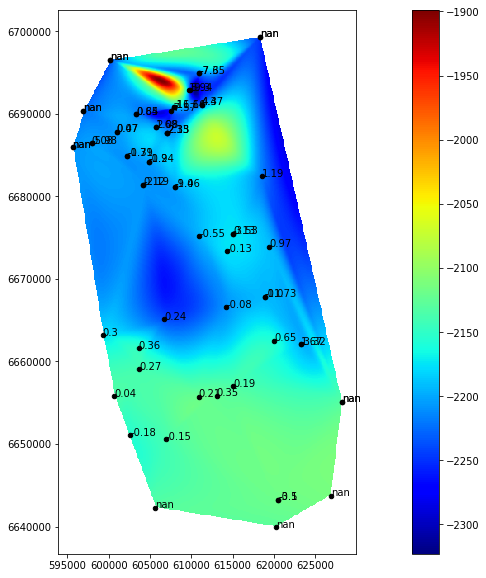

In [77]:
plot_surface(grid, dExtent, filtered, res=residuals)

### Residual Histogram

In [89]:
def plot_hist(data):
    """
    """
    values = data[:,2]
    values = values[~np.isnan(values)]
    rng = np.nanmin(values), np.nanmax(values)
    n, bins, _ = plt.hist(values, bins='auto',  range=rng)

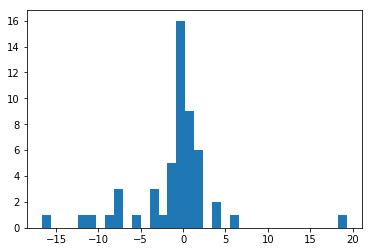

In [90]:
plot_hist(residuals)

In [ ]:
rng = np.nanmin(res_list), np.nanmax(res_list)
n, bins, _ = plt.hist(res_list, bins='auto',  range=rng)

In [ ]:
bins = (bins[1:] + bins[:-1]) / 2

In [ ]:
plt.bar(bins, n, width=0.5, color='g')

### Regrid using data with outliers kicked out

In [ ]:
#Filter the input data on the results of tghe first gridding
condition1 = ( (res_df.residual > -5) & (res_df.residual < 5) )
condition2 = res_df.residual.isna()

filteredDf = res_df[condition1 | condition2]

In [ ]:
#Pull data from the filtered pandas data frame into 1d arrays
xFilt, yFilt , zFilt = filteredDf.x , filteredDf.y , filteredDf.z

In [ ]:
#Create numpy arrays of point co-ordinates and then values from input data
pointsFilt = np.array(list(zip(xFilt, yFilt)))
valuesFilt = zFilt

In [ ]:
#Perform interpolation of data in to the specified grid using scipy
reGridded = griddata(pointsFilt, valuesFilt, (grid_x, grid_y), method='cubic')

In [ ]:
#Determine array value limits for contour plotting
contourInt = 5
contourMin = round(int(np.nanmin(reGridded)), -1)
contourMax = round(int(np.nanmax(reGridded)), -1)
contours = np.arange(contourMin, contourMax, contourInt)

In [ ]:
#Re-extract residuals
newXcor, newYcor = get_top_coords(xFilt, yFilt)

In [ ]:
#Extract the value of the grid at the well top locations
z_reGridded = reGridded[(newXcor, newYcor)]
newResiduals = zFilt - z_reGridded

In [ ]:
#Put the residuals in to a dataframe for visualisation
d_regrid = {'x': xFilt, 'y': yFilt, 'z':zFilt, 'z_regridded': z_reGridded, 'residual': newResiduals}
reGrid_df = pd.DataFrame(data=d_regrid)
reGrid_df

In [ ]:
#Plot image of grid, this time with residual annotations
plt.figure(figsize=(30,12))
plt.imshow(reGridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()

#ContourLevels
plt.contour(reGridded.T, extent=extent, levels=contours, colors='k', linestyles='-', linewidths=1)

#Plot well tops and residuals
plt.scatter(xFilt, yFilt, s=20, c='gray')


new_res_list = newResiduals.tolist()
new_res_list_txt = [str(round(i, 2)) for i in new_res_list]


for i, txt in enumerate(new_res_list_txt):
    plt.annotate(txt, (x[i], y[i]) , size=10)

In [ ]:
zg=reGridded.ravel()
print(zg)

In [ ]:
xg=grid_x.tolist()
yg=grid_y.tolist()
datagrid = pd.DataFrame({'Easting': grid_x.ravel(), 'Northing': grid_y.ravel(), 'Values': -reGridded.ravel()}, columns=['Easting', 'Northing','Values'])

In [ ]:
datagrid[np.isnan(datagrid)] = 0

In [ ]:
datagrid.to_csv('11_2_regridded_c.csv')

In [ ]:
#Update histogram
rng2 = np.nanmin(new_res_list), np.nanmax(new_res_list)
n, bins, _ = plt.hist(new_res_list, bins='auto',  range=rng2)

### KDTree

In [ ]:
from scipy import spatial

In [ ]:
#Create sensible grid outline of integers. Now hardcoded...
extent = [596000, 628500, 6640000, 6700000] #Sensible numbers from observed Xmin and Ymin
grid_int = 2000 #Hard coded grid spacing
#Create arrays of the x and y axis
x_points = int((extent[1] - extent[0]) / grid_int)
y_points = int((extent[3] - extent[2]) / grid_int)

In [ ]:
#Create the grid. interval expressed by complex numbers
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(x_points), extent[2]:extent[3]:complex(y_points)]

In [ ]:
#Create numpy arrays of point co-ordinates and then values from input data
points = np.array(list(zip(x, y)))
values = z

In [ ]:
#create kd index
tree = spatial.KDTree(points.tolist())

In [ ]:
keep=list(set(tree.query(list(zip(grid_x.ravel(), grid_y.ravel())))[1]))
xk,yk,zk = x[keep],y[keep],z[keep]

In [ ]:
inds = [i for i in range(x.size)]
blinds = [i for i in inds if i not in keep]
xb, yb, zb = x[blinds] , y[blinds] , z[blinds]

In [ ]:
plt.scatter(xb, yb, color = 'r', s=40, label='blind test')
plt.scatter(xk, yk, color='blue', s=20, label='keep')
plt.legend()

In [ ]:
keepdist=list(set(tree.query(list(zip(grid_x.ravel(), grid_y.ravel())))[0]))

In [ ]:
#Create numpy arrays of point co-ordinates and then values from input data
points = np.array(list(zip(xk, yk)))
values = zk

In [ ]:
#Perform interpolation of data in to the specified grid using scipy
gridded = griddata(points, values, (grid_x, grid_y), method='cubic')

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(gridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()


plt.scatter(xk, yk, s=10, c='k', label = 'Keep')
plt.scatter(xb, yb, s=10, c = 'r', label='Blind Test')
plt.legend()

### KD Residuals

In [ ]:
gridded.shape

In [ ]:
# The inline, crossline locations you just provided. Also Grid extent, but as indices given by grid.shape
corners_ix = np.array([[0,  0],
                       [0, 29],
                       [15, 0]])

In [ ]:
transform = bruges.transform.CoordTransform(corners_ix, corners_xy)

In [ ]:
#Re-extract residuals
kdXcor, kdYcor = get_top_coords(xk, yk)

In [ ]:
#Extract the value of the grid at the well top locations
kdGridPoint = gridded[(kdXcor, kdYcor)]
kdResiduals = zk - kdGridPoint

In [ ]:
kd_dict = {'x' : xk,
          'y' : yk,
          'z' : zk,
          'zkd' : kdGridPoint,
          'kdResidual' : kdResiduals} 

In [ ]:
kd_df = pd.DataFrame(data=kd_dict)

In [ ]:
#Update histogram
kd_res_list = kdResiduals.tolist()
rng3 = np.nanmin(kd_res_list), np.nanmax(kd_res_list)
n, bins, _ = plt.hist(kd_res_list, bins='auto',  range=rng3)

In [ ]:
bins = (bins[1:] + bins[:-1]) / 2

In [ ]:
plt.bar(bins, n, width=1, color='g')

In [ ]:
#Blind Test Residuals
BkdXcor, BkdYcor = get_top_coords(xb, yb)

In [ ]:
#Extract the value of the grid at the well top locations
BkdGridPoint = gridded[(BkdXcor, BkdYcor)]
BkdResiduals = zb - BkdGridPoint

In [ ]:
#Update histogram
Bkd_res_list = BkdResiduals.tolist()
rng4 = np.nanmin(Bkd_res_list), np.nanmax(Bkd_res_list)
n, bins, _ = plt.hist(Bkd_res_list, bins='auto',  range=rng4)

In [ ]:
bins = (bins[1:] + bins[:-1]) / 2

In [ ]:
plt.bar(bins, n, width=1, color='g')

### 2d Fourier Transform

In [ ]:
#Subset data to rectangle. In final version, will have already selected rectangle in ipyvolume phase

In [ ]:
gridded.shape

In [ ]:
ft = np.fft.fft2(gridded)